## Домашняя работа №4


**Махметов Ансар БЭК205, Гончарова Александра БЭК205, Нукетаев Мейиржан БЭК205**

 ## 1) Собираем датасет, парсим марку hyundai на [auto.ru](https://auto.ru/moskva/cars/hyundai/all/?page)

![Hyundai elantra](https://images.drive.ru/i/0/5e71d29aec05c40a6a00002a.jpg)

In [79]:
import requests, time
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import pandas as pd


def pars(page,city):  # Создаем функцию самого парсинга, передаем в качестве аргумента номер страницы и город
    adress = 'https://auto.ru/'+city+'/cars/hyundai/all/?page={}'.format(page)
    header = {  # Так называемый "отпечаток браузера", как можно больше аргументов чтобы было правдоподобней
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'accept-encoding': 'gzip, deflate, br',
        'accept-language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
        'cache-control': 'no-cache',
        'dnt': '1',
        'pragma': 'no-cache',
        'sec-fetch-mode': 'navigate',
        'sec-fetch-site': 'none',
        'sec-fetch-user': '?1',
        'upgrade-insecure-requests': '1',
        'user-agent': UserAgent().chrome}

    response = requests.get(adress, headers=header)
    tree = BeautifulSoup(response.content, 'html.parser')
    cars = tree.find_all('div', {'class': 'ListingItem-module__description'})  # Блоки с информацией о каждой машине
    infa = []  # Сюда будем добавлять словари с данными по каждой машине
    for car in cars:
        if "Электро" in car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[0].text:
            continue
        year = car.find('div', {'class': 'ListingItem-module__year'}).text  # Год машины и т.д. вниз
        kilometrage = car.find('div', {'class': 'ListingItem-module__kmAge'}).text
        try:  # Здесь может быть так что у машины нет цены
            price = car.find('div', {'class': 'ListingItemPrice-module__content'}).text
        except:
            price = 'No price'
        transmission = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[1].text
        engine_capacity = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[0].text.split("\u2009")[
            0]
        horse_power = "".join(
            car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[0].text.split("\u2009")[2].split(
                '\xa0'))
        fuel = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[0].text.split("\u2009")[4]
        drive = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[3].text
        kuzov = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[2].text
        color = car.find_all('div', {'class': 'ListingItemTechSummaryDesktop__cell'})[4].text
        infa.append({'Название': car.h3.a.text,  # Добавляем все переменные в словарь
                     'Год': year,
                     'Километраж': "".join(kilometrage.split("\xa0")),
                     'Стоимость': "".join(price.split("\xa0")),
                     'КПП': transmission,
                     'Объем двигателя': engine_capacity,
                     'Мощность': horse_power,
                     'Топливо': fuel,
                     'Привод': drive,
                     'Кузов': kuzov,
                     'Цвет': color
                     })
    return infa  # Возвращаем словарь


information_moscow = []  # Массив с итоговой информацией
for i in range(1, 21):
    information_moscow.extend(pars(i,"moskva"))  # Расширяем итоговый словарь

**Так как сайт постоянно обновляется, мы каждый день прогоняли парсер и фиксили ошибки(появление электромашин, у которых нет многих характеристик; нахождение машин с недостающимися признаками, проданные машины и т.д.) и на 6.06.21 ошибок нет**

## 2) Обработка данных, удаление выбросов

In [80]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
table = pd.DataFrame(information_moscow)
table

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет
0,Hyundai Solaris II Рестайлинг,2021,Новый,от 1146000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,Elegance
1,Hyundai Solaris I Рестайлинг,2015,171003км,629000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,чёрный
2,Hyundai Solaris II,2018,35000км,910000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,бежевый
3,Hyundai Creta I,2018,78000км,1150000₽,автомат,2.0 л,149л.с.,Бензин,передний,внедорожник 5 дв.,серый
4,Hyundai Sonata VIII (DN8),2021,Новый,от 1888000₽,автомат,2.5 л,180л.с.,Бензин,передний,седан,Way
...,...,...,...,...,...,...,...,...,...,...,...
754,Hyundai Santa Fe IV Рестайлинг,2021,Новый,от 2774150₽,автомат,2.5 л,180л.с.,Бензин,полный,внедорожник 5 дв.,Prestige
755,Hyundai Solaris I,2012,83551км,444000₽,механика,1.6 л,123л.с.,Бензин,передний,седан,белый
756,Hyundai Santa Fe III Рестайлинг,2015,132234км,1678000₽,автомат,2.2 л,200л.с.,Дизель,полный,внедорожник 5 дв.,белый
757,Hyundai Solaris II Рестайлинг,2021,Новый,от 1092000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,Elegance + Prestige + Safety


In [81]:
def prepare_data(table):
    for i in range(len(table["Километраж"])): 
        if table["Километраж"][i].find("км") != -1: # удаляем единицу измерения, то есть "км"
            table["Километраж"][i] = int(table["Километраж"][i][:table["Километраж"][i].find("км")])
        elif table["Километраж"][i].find("Новый") != -1: # новые машины без пробега(километража) заменяем на нулевой пробег
            table["Километраж"][i] = 0
            
    for i in range(len(table["Стоимость"])):
        if table["Стоимость"][i].find("₽") != -1:
            table["Стоимость"][i] = table["Стоимость"][i][:table["Стоимость"][i].find("₽")]
        if table["Стоимость"][i].find("от") != -1:
            table["Стоимость"][i] = table["Стоимость"][i][table["Стоимость"][i].find("от") + 2:]
            # удаялем единицу измерения, если цена варьируется, начиная с какой-то суммы, берем минимальную
        elif table["Стоимость"][i].find("до") != -1:
            table["Стоимость"][i] = table["Стоимость"][i][table["Стоимость"][i].find("до") + 2:]
            # удаялем единицу измерения, если цена варьируется до какой-то суммы, берем максимальную
        elif table["Стоимость"][i].find("No price") != -1:
            table["Стоимость"][i] = np.NaN
            # машины без цен(проданные), заменяем на NaN
    for i in range(len(table["Мощность"])):
        table["Мощность"][i] = int(table["Мощность"][i][:table["Мощность"][i].find("л.с.")])
        
    for i in range(len(table["Объем двигателя"])):
        table["Объем двигателя"][i] = float(table["Объем двигателя"][i][:table["Объем двигателя"][i].find("л")])
    
    colors = {}
    for i in table["Цвет"]:
        colors[i] = colors.get(i, 1) + 1
    colors_list = sorted(colors.items(), key=lambda x:x[1], reverse=True)
    popular_color = [i[0] for i in colors_list[:7]] # выбираем самые популярные цвета
    
    for i in range(len(table["Цвет"])):
        if table["Цвет"][i] not in popular_color:
            table["Цвет"][i] = np.NaN # заменяем все непопулярные цвета на NaN
    for i in range(len(table['Название'])):
        if table['Название'][i].find('(') != -1:
            table['Название'][i] = table['Название'][i][:table['Название'][i].find("(")]
        if table['Название'][i].lower().find("рестайлинг") != -1:
            table['Название'][i] = np.NaN # заменяем рестайлинговые машины на NaN 
        
    table = table.dropna(how='any') 
    # удаляем строчки, где хотя бы в одном признаке есть NaN, так как нас не интересуют непопулярные цвета, проданные машины, 
    # тюнингованные машины, так как это может влиять на стоимость
    table["Стоимость"] = np.array(table["Стоимость"], int) # перевели столбец со стоимостью автомобиля в int
    
        
    return table

In [82]:
table = prepare_data(table).sort_values("Название").reset_index(drop=True) # обновили индексацию и отсортировали таблицу по названиям
table

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет
0,Hyundai Accent II ТагАЗ,2005,274613,215000,автомат,1.5,102,Бензин,передний,седан,серебристый
1,Hyundai Accent II ТагАЗ,2008,115000,245000,механика,1.5,102,Бензин,передний,седан,чёрный
2,Hyundai Accent II ТагАЗ,2004,177000,225000,автомат,1.5,102,Бензин,передний,седан,серебристый
3,Hyundai Accent II ТагАЗ,2005,93382,159000,механика,1.5,102,Бензин,передний,седан,чёрный
4,Hyundai Accent II ТагАЗ,2008,173344,275000,механика,1.5,102,Бензин,передний,седан,чёрный
...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2010,124000,740000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый
260,Hyundai ix35 I,2012,175174,750000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый
261,Hyundai ix35 I,2011,165000,900000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,чёрный
262,Hyundai ix55,2009,160600,1250000,автомат,3.0,239,Дизель,полный,внедорожник 5 дв.,белый


## 3) Создание новых признаков, работа с pandas, графики

**Используя выше написанную функцию, распарсим данные о hyundai в другом городе(Санкт-Петербург)**

In [83]:
information_saint_p = []
for i in range(1, 21):
    information_saint_p.extend(pars(i,"leningradskaya_oblast"))

In [84]:
table1 = pd.DataFrame(information_saint_p)
table1

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет
0,Hyundai Solaris I,2013,138000км,590000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,чёрный
1,Hyundai Starex I,1999,300000км,450000₽,механика,2.5 л,80л.с.,Дизель,полный,минивэн,коричневый
2,Hyundai Solaris II,2018,54200км,814000₽,механика,1.6 л,123л.с.,Бензин,передний,седан,чёрный
3,Hyundai Sonata VIII (DN8),2019,13026км,1869000₽,автомат,2.5 л,180л.с.,Бензин,передний,седан,красный
4,Hyundai Santa Fe IV Рестайлинг,2021,Новый,от 2337000₽,автомат,2.5 л,180л.с.,Бензин,полный,внедорожник 5 дв.,Family
...,...,...,...,...,...,...,...,...,...,...,...
739,Hyundai Solaris II Рестайлинг,2021,Новый,от 1016000₽,автомат,1.6 л,123л.с.,Бензин,передний,седан,Elegance + Safety
740,Hyundai i30 II Рестайлинг,2016,85000км,780000₽,механика,1.6 л,130л.с.,Бензин,передний,хэтчбек 5 дв.,серебристый
741,Hyundai Starex I Рестайлинг,2002,260000км,750000₽,автомат,2.5 л,101л.с.,Дизель,полный,минивэн,серый
742,Hyundai Santa Fe IV Рестайлинг,2021,Новый,от 3252000₽,робот,2.2 л,199л.с.,Дизель,полный,внедорожник 5 дв.,High-Tech 7 мест + Exclusive


**Используем функцию с обработкой данных**

In [85]:
table1 = prepare_data(table1).sort_values("Название").reset_index(drop=True)
table1

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет
0,Hyundai Accent II ТагАЗ,2009,127000,330000,автомат,1.5,102,Бензин,передний,седан,чёрный
1,Hyundai Accent II ТагАЗ,2008,230000,239000,механика,1.5,102,Бензин,передний,седан,синий
2,Hyundai Accent II ТагАЗ,2008,134274,298585,механика,1.5,102,Бензин,передний,седан,серебристый
3,Hyundai Accent II ТагАЗ,2011,135000,265000,механика,1.5,102,Бензин,передний,седан,серебристый
4,Hyundai Accent II,2000,186000,80000,механика,1.3,86,Бензин,передний,седан,синий
...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2012,56005,899000,автомат,2.0,150,Бензин,полный,внедорожник 5 дв.,чёрный
260,Hyundai ix35 I,2011,129000,875000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый
261,Hyundai ix35 I,2013,125325,929000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,серый
262,Hyundai ix35 I,2012,138000,780000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый


In [86]:
km_per_year_moscow = [] # в Москве
j = 0
for i in table["Километраж"]:
    km_per_year_moscow.append(round(i / (2022 - int(table["Год"][j]))))
    j += 1
table["Километраж за год"] = km_per_year_moscow #посчитали средний километраж за год с момента выпуска машины
table

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год
0,Hyundai Accent II ТагАЗ,2005,274613,215000,автомат,1.5,102,Бензин,передний,седан,серебристый,16154
1,Hyundai Accent II ТагАЗ,2008,115000,245000,механика,1.5,102,Бензин,передний,седан,чёрный,8214
2,Hyundai Accent II ТагАЗ,2004,177000,225000,автомат,1.5,102,Бензин,передний,седан,серебристый,9833
3,Hyundai Accent II ТагАЗ,2005,93382,159000,механика,1.5,102,Бензин,передний,седан,чёрный,5493
4,Hyundai Accent II ТагАЗ,2008,173344,275000,механика,1.5,102,Бензин,передний,седан,чёрный,12382
...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2010,124000,740000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,10333
260,Hyundai ix35 I,2012,175174,750000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,17517
261,Hyundai ix35 I,2011,165000,900000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,чёрный,15000
262,Hyundai ix55,2009,160600,1250000,автомат,3.0,239,Дизель,полный,внедорожник 5 дв.,белый,12354


In [87]:
km_per_year_saint_p = [] # в Питере
j = 0
for i in table1["Километраж"]:
    km_per_year_saint_p.append(round(i / (2022 - int(table1["Год"][j]))))
    j += 1
table1["Километраж за год"] = km_per_year_saint_p #посчитали средний километраж за год с момента выпуска машины
table1

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год
0,Hyundai Accent II ТагАЗ,2009,127000,330000,автомат,1.5,102,Бензин,передний,седан,чёрный,9769
1,Hyundai Accent II ТагАЗ,2008,230000,239000,механика,1.5,102,Бензин,передний,седан,синий,16429
2,Hyundai Accent II ТагАЗ,2008,134274,298585,механика,1.5,102,Бензин,передний,седан,серебристый,9591
3,Hyundai Accent II ТагАЗ,2011,135000,265000,механика,1.5,102,Бензин,передний,седан,серебристый,12273
4,Hyundai Accent II,2000,186000,80000,механика,1.3,86,Бензин,передний,седан,синий,8455
...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2012,56005,899000,автомат,2.0,150,Бензин,полный,внедорожник 5 дв.,чёрный,5600
260,Hyundai ix35 I,2011,129000,875000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,11727
261,Hyundai ix35 I,2013,125325,929000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,серый,13925
262,Hyundai ix35 I,2012,138000,780000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,13800


**Если считать процентную ставку банка 5.6% и срок погашения 5 лет, посчитаем ежемесячные выплаты аннуитетным платежом(в случае кредита)**

In [88]:
coef = 0.056 / 12
month_payments_moscow = [round(i * ((coef * (1 + coef) ** 60) /((1 + coef) ** 60 - 1))) for i in table["Стоимость"]]
table["Ежемесячные выплаты(кредит)"] = month_payments_moscow
table

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год,Ежемесячные выплаты(кредит)
0,Hyundai Accent II ТагАЗ,2005,274613,215000,автомат,1.5,102,Бензин,передний,седан,серебристый,16154,4117
1,Hyundai Accent II ТагАЗ,2008,115000,245000,механика,1.5,102,Бензин,передний,седан,чёрный,8214,4691
2,Hyundai Accent II ТагАЗ,2004,177000,225000,автомат,1.5,102,Бензин,передний,седан,серебристый,9833,4308
3,Hyundai Accent II ТагАЗ,2005,93382,159000,механика,1.5,102,Бензин,передний,седан,чёрный,5493,3044
4,Hyundai Accent II ТагАЗ,2008,173344,275000,механика,1.5,102,Бензин,передний,седан,чёрный,12382,5266
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2010,124000,740000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,10333,14169
260,Hyundai ix35 I,2012,175174,750000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,17517,14361
261,Hyundai ix35 I,2011,165000,900000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,чёрный,15000,17233
262,Hyundai ix55,2009,160600,1250000,автомат,3.0,239,Дизель,полный,внедорожник 5 дв.,белый,12354,23934


In [89]:
month_payments_saint_p = [round(i * ((coef * (1 + coef) ** 60) /((1 + coef) ** 60 - 1))) for i in table1["Стоимость"]]
table1["Ежемесячные выплаты(кредит)"] = month_payments_saint_p
table1

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год,Ежемесячные выплаты(кредит)
0,Hyundai Accent II ТагАЗ,2009,127000,330000,автомат,1.5,102,Бензин,передний,седан,чёрный,9769,6319
1,Hyundai Accent II ТагАЗ,2008,230000,239000,механика,1.5,102,Бензин,передний,седан,синий,16429,4576
2,Hyundai Accent II ТагАЗ,2008,134274,298585,механика,1.5,102,Бензин,передний,седан,серебристый,9591,5717
3,Hyundai Accent II ТагАЗ,2011,135000,265000,механика,1.5,102,Бензин,передний,седан,серебристый,12273,5074
4,Hyundai Accent II,2000,186000,80000,механика,1.3,86,Бензин,передний,седан,синий,8455,1532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2012,56005,899000,автомат,2.0,150,Бензин,полный,внедорожник 5 дв.,чёрный,5600,17213
260,Hyundai ix35 I,2011,129000,875000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,11727,16754
261,Hyundai ix35 I,2013,125325,929000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,серый,13925,17788
262,Hyundai ix35 I,2012,138000,780000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,13800,14935


**Средняя начисленная заработная плата в Москве равна 88845р, в Питере-62513р по версии росстата. Тогда посчитаем за сколько месяцев житель Москвы/Питера сможет погасить кредит, если будет отдавать половину от своей зарплаты.**

In [90]:
from math import log
x = 88845 / 2 # средняя зарплата в Москве, деленная на два
month_moscow = [round(log((coef / (x / i - coef)) + 1) / log(1 + coef)) for i in table["Стоимость"]] 
# через формулу аннуитентного платежа выразил месяцы погашения
table["Время погашения кредита при средней заработной плате(в месяцах)"] = month_moscow
table

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год,Ежемесячные выплаты(кредит),Время погашения кредита при средней заработной плате(в месяцах)
0,Hyundai Accent II ТагАЗ,2005,274613,215000,автомат,1.5,102,Бензин,передний,седан,серебристый,16154,4117,5
1,Hyundai Accent II ТагАЗ,2008,115000,245000,механика,1.5,102,Бензин,передний,седан,чёрный,8214,4691,6
2,Hyundai Accent II ТагАЗ,2004,177000,225000,автомат,1.5,102,Бензин,передний,седан,серебристый,9833,4308,5
3,Hyundai Accent II ТагАЗ,2005,93382,159000,механика,1.5,102,Бензин,передний,седан,чёрный,5493,3044,4
4,Hyundai Accent II ТагАЗ,2008,173344,275000,механика,1.5,102,Бензин,передний,седан,чёрный,12382,5266,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2010,124000,740000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,10333,14169,17
260,Hyundai ix35 I,2012,175174,750000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,17517,14361,18
261,Hyundai ix35 I,2011,165000,900000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,чёрный,15000,17233,21
262,Hyundai ix55,2009,160600,1250000,автомат,3.0,239,Дизель,полный,внедорожник 5 дв.,белый,12354,23934,30


In [91]:
y = 62513 / 2 # средняя зарплата в Питере, деленная на два
month_saint_p = [round(log((coef / (y / i - coef)) + 1) / log(1 + coef)) for i in table1["Стоимость"]] 
# через формулу аннуитентного платежа выразил месяцы погашения
table1["Время погашения кредита при средней заработной плате(в месяцах)"] = month_saint_p
table1

,Название,Год,Километраж,Стоимость,КПП,Объем двигателя,Мощность,Топливо,Привод,Кузов,Цвет,Километраж за год,Ежемесячные выплаты(кредит),Время погашения кредита при средней заработной плате(в месяцах)
0,Hyundai Accent II ТагАЗ,2009,127000,330000,автомат,1.5,102,Бензин,передний,седан,чёрный,9769,6319,11
1,Hyundai Accent II ТагАЗ,2008,230000,239000,механика,1.5,102,Бензин,передний,седан,синий,16429,4576,8
2,Hyundai Accent II ТагАЗ,2008,134274,298585,механика,1.5,102,Бензин,передний,седан,серебристый,9591,5717,10
3,Hyundai Accent II ТагАЗ,2011,135000,265000,механика,1.5,102,Бензин,передний,седан,серебристый,12273,5074,9
4,Hyundai Accent II,2000,186000,80000,механика,1.3,86,Бензин,передний,седан,синий,8455,1532,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Hyundai ix35 I,2012,56005,899000,автомат,2.0,150,Бензин,полный,внедорожник 5 дв.,чёрный,5600,17213,31
260,Hyundai ix35 I,2011,129000,875000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,белый,11727,16754,30
261,Hyundai ix35 I,2013,125325,929000,автомат,2.0,150,Бензин,передний,внедорожник 5 дв.,серый,13925,17788,32
262,Hyundai ix35 I,2012,138000,780000,механика,2.0,150,Бензин,полный,внедорожник 5 дв.,серый,13800,14935,27


**Посчитаем количество машин в городах одного года**

In [92]:
year_moscow = {}
for i in table["Год"]:
    year_moscow[i] = year_moscow.get(i, 1) + 1
year = []
number = []
for i in sorted(year_moscow.items(), key=lambda x:x[0]):
    year.append(i[0])
    number.append(i[1])

In [93]:
year_saint_p = {}
for i in table1["Год"]:
    year_saint_p[i] = year_saint_p.get(i, 1) + 1
year1 = []
number1 = []
for i in sorted(year_saint_p.items(), key=lambda x:x[0]):
    year1.append(i[0])
    number1.append(i[1])

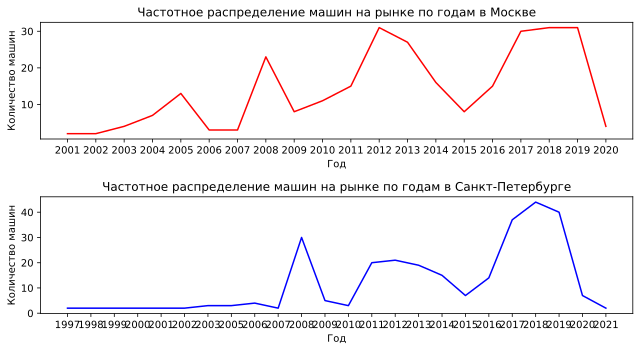

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax.plot(year, number, "r")
ax2.plot(year1, number1, "b")
ax.set_xlabel("Год")
ax.set_ylabel('Количество машин')
ax.set_title('Частотное распределение машин на рынке по годам в Москве')
ax2.set_xlabel("Год")
ax2.set_ylabel('Количество машин')
ax2.set_title('Частотное распределение машин на рынке по годам в Санкт-Петербурге')
fig.tight_layout()
plt.show()

**Графики практически идентичны, для сравнения стоило бы взять другой город, но данных по другим городам было не так много.
Можно заметить, что машин 18-19-года марки Hyundai больше всего на рынках двух городов(информация на 06.06.21)**

**Группировка и агрегация данных**

In [95]:
df_moscow = table[["Название", "Год", "Стоимость"]] # создаем новые датафреймы на основе имеющихся, по Москве и Санкт-Петербургу
df_saint_p = table1[["Название", "Год", "Стоимость"]]
df_moscow = df_moscow.groupby(["Название", "Год"]).aggregate(lambda x: list(x)).reset_index()
df_saint_p = df_saint_p.groupby(["Название", "Год"]).aggregate(lambda x: list(x)).reset_index()
df_moscow["Стоимость"] = [round(sum(i) / len(i)) for i in df_moscow["Стоимость"]] # средняя стоимость машины того же года по Москве и Санкт-Петербургу
df_saint_p["Стоимость"] = [round(sum(i) / len(i)) for i in df_saint_p["Стоимость"]]
df = pd.merge(df_moscow, df_saint_p, on = ['Название','Год'])
df['Стоимость'] = df.filter(like='Стоимость').values.tolist()
df = df.rename({"Стоимость_x" : "Стоимость по Москве", "Стоимость_y" : "Стоимость по Санкт-Петербургу", "Стоимость" : "Среднее"}, axis=1)
df["Среднее"] = [round(sum(i) / len(i)) for i in df["Среднее"]]
df["Название"] = [i.replace("Hyundai", "") for i in df["Название"]]
df

,Название,Год,Стоимость по Москве,Стоимость по Санкт-Петербургу,Среднее
0,Accent II ТагАЗ,2008,242500,268792,255646
1,Avante V,2011,699000,532000,615500
2,Creta I,2016,1122143,1164905,1143524
3,Creta I,2017,1121556,1153143,1137350
4,Creta I,2018,1113167,1207214,1160190
5,Creta I,2019,1303667,1302500,1303084
6,Elantra III,2003,190000,210000,200000
7,Elantra V,2015,803500,713500,758500
8,Elantra VI,2017,858500,963833,911166
9,Elantra VI,2019,1449000,1265500,1357250


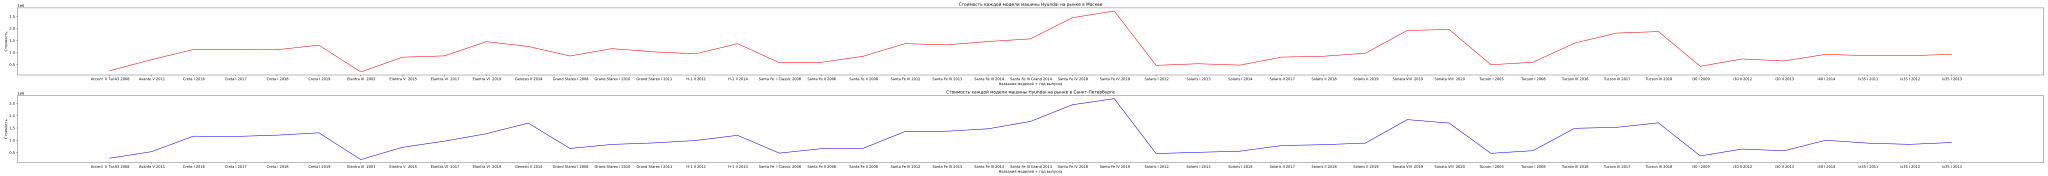

In [96]:
fig = plt.figure(figsize=(80, 7))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
cars = [df["Название"][i] + " " + str(df["Год"][i]) for i in range(len(df["Название"]))]
ax.plot(cars, df["Стоимость по Москве"], "r")
ax2.plot(cars, df["Стоимость по Санкт-Петербургу"], "b")
ax.set_title("Стоимость каждой модели машины Hyundai на рынке в Москве")
ax2.set_title("Стоимость каждой модели машины Hyundai на рынке в Санкт-Петербурге")
ax.set_xlabel("Названия моделей + год выпуска")
ax2.set_xlabel("Названия моделей + год выпуска")
ax.set_ylabel("Стоимость")
ax2.set_ylabel("Стоимость")
fig.tight_layout()
plt.show()

**Стоимость машин идентична(с точностью до несколько десятков тысяч) в двух городах из-за того, что мы брали среднюю цену всех машин одной модели(в одном городе) и таким образом нормировали значения**

**Посчитаем время погашения кредита на каждую модель при средней номинальной заработной плате и построим графики**

In [97]:
x = 88845 / 2 # средняя зарплата в Москве, деленная на два
profit_moscow = [round(log((coef / (x / i - coef)) + 1) / log(1 + coef)) for i in df["Стоимость по Москве"]] 
# через формулу аннуитентного платежа выразил месяцы погашения
df["Время погашения в Москве при средней заработной плате(в месяцах)"] = profit_moscow

In [98]:
y = 62513 / 2 # средняя зарплата в Питере, деленная на два
profit_saint_p = [round(log((coef / (y / i - coef)) + 1) / log(1 + coef)) for i in df["Стоимость по Санкт-Петербургу"]] 
# через формулу аннуитентного платежа выразил месяцы погашения
df["Время погашения в Санкт-Петербурге при средней заработной плате(в месяцах)"] = profit_saint_p
df

,Название,Год,Стоимость по Москве,Стоимость по Санкт-Петербургу,Среднее,Время погашения в Москве при средней заработной плате(в месяцах),Время погашения в Санкт-Петербурге при средней заработной плате(в месяцах)
0,Accent II ТагАЗ,2008,242500,268792,255646,6,9
1,Avante V,2011,699000,532000,615500,16,18
2,Creta I,2016,1122143,1164905,1143524,27,41
3,Creta I,2017,1121556,1153143,1137350,27,41
4,Creta I,2018,1113167,1207214,1160190,27,43
5,Creta I,2019,1303667,1302500,1303084,32,46
6,Elantra III,2003,190000,210000,200000,4,7
7,Elantra V,2015,803500,713500,758500,19,24
8,Elantra VI,2017,858500,963833,911166,20,33
9,Elantra VI,2019,1449000,1265500,1357250,35,45


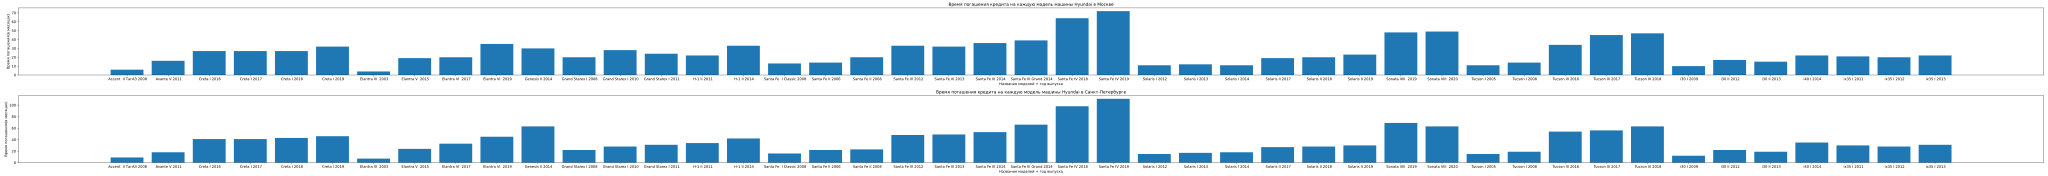

In [99]:
fig = plt.figure(figsize=(80, 7))
ax = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
cars = [df["Название"][i] + " " + str(df["Год"][i]) for i in range(len(df["Название"]))]
ax.bar(cars, df["Время погашения в Москве при средней заработной плате(в месяцах)"])
ax2.bar(cars, df["Время погашения в Санкт-Петербурге при средней заработной плате(в месяцах)"])
ax.set_title("Время погашения кредита на каждую модель машины Hyundai в Москве")
ax2.set_title("Время погашения кредита на каждую модель машины Hyundai в Санкт-Петербурге")
ax.set_xlabel("Названия моделей + год выпуска")
ax2.set_xlabel("Названия моделей + год выпуска")
ax.set_ylabel("Время погашения(в месяцах)")
ax2.set_ylabel("Время погашения(в месяцах)")
fig.tight_layout()
plt.show()

In [100]:
what_transmission_moscow = {}
for i in table["КПП"]:
    what_transmission_moscow[i] = what_transmission_moscow.get(i, 1) + 1
what_transmission_moscow

{'автомат': 198, 'механика': 68}

In [101]:
what_transmission_saint_p = {}
for i in table1["КПП"]:
    what_transmission_saint_p[i] = what_transmission_saint_p.get(i, 1) + 1
what_transmission_saint_p

{'автомат': 191, 'механика': 71, 'робот': 5}

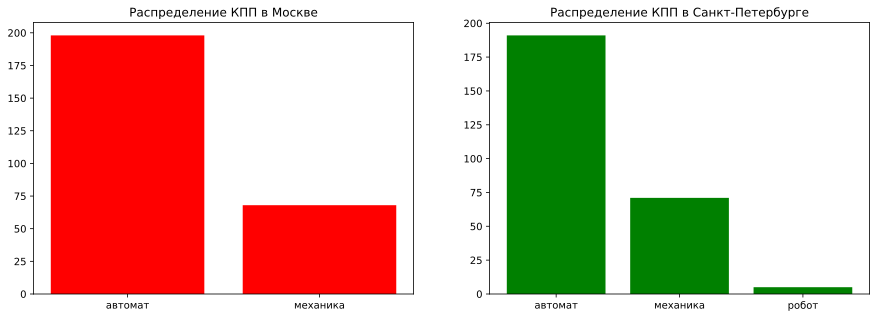

In [102]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.bar(what_transmission_moscow.keys(), what_transmission_moscow.values(), color='r')
ax2.bar(what_transmission_saint_p.keys(), what_transmission_saint_p.values(),  color='g')
ax.set_title('Распределение КПП в Москве')
ax2.set_title('Распределение КПП в Санкт-Петербурге')
plt.show()

In [103]:
what_fuel_moscow = {}
for i in table["Топливо"]:
    what_fuel_moscow[i] = what_fuel_moscow.get(i, 1) + 1
what_fuel_moscow

{'Бензин': 213, 'Дизель': 53}

In [104]:
what_fuel_saint_p = {}
for i in table1["Топливо"]:
    what_fuel_saint_p[i] = what_fuel_saint_p.get(i, 1) + 1
what_fuel_saint_p

{'Бензин': 216, 'Дизель': 50}

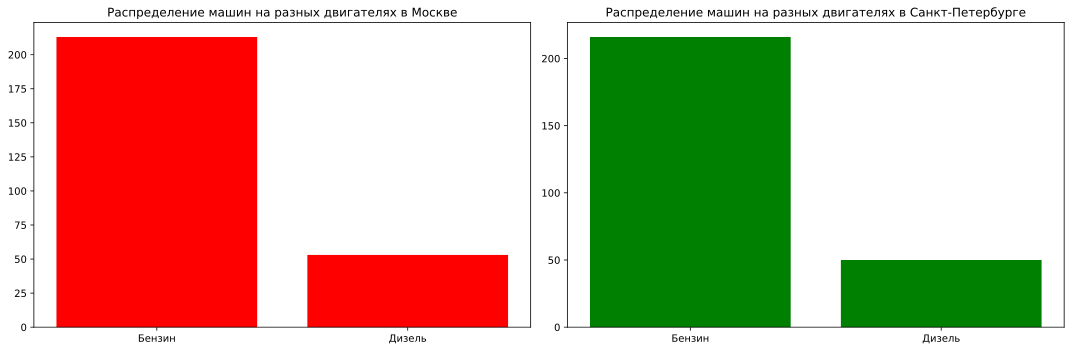

In [105]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.bar(what_fuel_moscow.keys(), what_fuel_moscow.values(), color='r')
ax2.bar(what_fuel_saint_p.keys(), what_fuel_saint_p.values(),  color='g')
ax.set_title('Распределение машин на разных двигателях в Москве')
ax2.set_title('Распределение машин на разных двигателях в Санкт-Петербурге')
fig.tight_layout()
plt.show()